In [1]:
#import proper tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Access the csv files and remove the information that isn't necessary for this analysis
anne_df = pd.read_csv('Anne.csv').drop(['Unnamed: 0','File One','File Two'], axis=1)
sarah_df = pd.read_csv('Sarah.csv').drop(['Unnamed: 0','File One','File Two'], axis=1)

In [2]:
#add_confus adds columns to the dataframes that represent what kind of correct or incorrect they are
#in the style of a confusion matrix
def add_confus(mat):
    same = mat['Other Vowel'].isnull()
    diff = np.logical_not(mat['Other Vowel'].isnull())
    truth = mat['Correctness']
    falth = np.logical_not(mat['Correctness'])
    mix = lambda a,b: np.where(np.logical_and(a,b),True, False)
    mat['True Same'] = mix(same,truth)
    mat['False Same'] = mix(diff,falth)
    mat['True Different'] = mix(diff,truth)
    mat['False Different'] = mix(same,falth)

add_confus(anne_df)
add_confus(sarah_df)

In [3]:
t_types = [anne_df['Test Type'][i] for i in [1,26,51,76]]
confus = list(anne_df.columns[-4:])
def get_test_type_stats(mat):
    data = dict([])
    for t in t_types:
        temp = dict([])
        for c in confus:
            temp[c] = len( (np.where(mat[mat['Test Type']==t][c]))[0])
        data[t]=temp
    result = pd.DataFrame(data).T
    result.index.name = 'Test Type'
    return result

test_type_matrix = get_test_type_stats(anne_df)+get_test_type_stats(sarah_df)
test_type_matrix

,True Same,False Same,True Different,False Different
Test Type,,,,
BareVowel,25,0,25,0
SameCons,32,5,12,1
DiffCons,23,7,16,4
Words,8,1,29,12


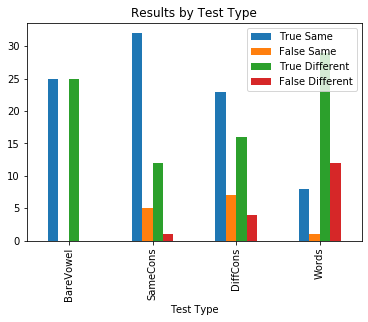

In [4]:
test_type_matrix.plot.bar(title='Results by Test Type')

In [5]:
#find_confused_vowels gets a dataframe with each pair of confused vowels and the frequency of that pair
def find_confused_vowels(mat):
    false_sames = mat[mat['False Same']==True]
    pairs = list(zip(false_sames['Vowel'],false_sames['Other Vowel']))
    for i in range(len(pairs)):
        if pairs[i][0] > pairs[i][1]:
            pairs[i] = (pairs[i][1],pairs[i][0])
    counts = {}
    for i in pairs:
        counts[i] = counts.get(i, 0) + 1
    return pd.DataFrame.from_dict(counts,orient='index')

#Then we aggregate the confusions between each listener
confused_vowels = find_confused_vowels(anne_df).append(find_confused_vowels(sarah_df))
confused_vowels.reset_index(inplace=True)
confused_vowels = confused_vowels.groupby(confused_vowels['index']).aggregate({0:'sum'})

#And then it'd be nice to have it clearly labeled and sorted
confused_vowels.index.name = "Vowels"
confused_vowels.columns = ["Times Confused"]
confused_vowels.sort_values(by='Times Confused',inplace=True,ascending=False)
confused_vowels

,Times Confused
Vowels,
"(ɛ, ɪ)",3
"(æ, ɪ)",2
"(a, eɪ)",1
"(a, ʌ)",1
"(eɪ, ɪ)",1
"(oʊ, u)",1
"(æ, ɛ)",1
"(æ, ʌ)",1
"(ɪ, ʊ)",1


In [6]:
#get_false_diff_data returns a Series containing each vowel
#and the number of times it was falsely marked as different from itself
def get_false_diff_data(mat):
    false_diffs = mat[mat['False Different']==True]
    false_diffs = false_diffs['Vowel'].value_counts()
    vowels = ['a','æ','eɪ','ɛ','i','ɪ','oʊ','u','ʊ','ʌ']
    result = pd.Series([0 for i in range(len(vowels))],index=vowels)
    result += false_diffs
    return result.fillna(0).astype('int32')

false_diff_data = get_false_diff_data(anne_df) + get_false_diff_data(sarah_df)

#And then we sort it and label it
false_diff_data.sort_values(ascending=False,inplace=True)
false_diff_data.index.name = 'Vowels'
false_diff_data = pd.DataFrame(false_diff_data)
false_diff_data.columns = ['Times Confused']
false_diff_data

,Times Confused
Vowels,
ʊ,4
ʌ,2
u,2
ɪ,2
ɛ,2
eɪ,2
a,2
i,1
oʊ,0


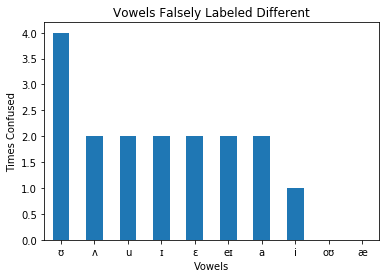

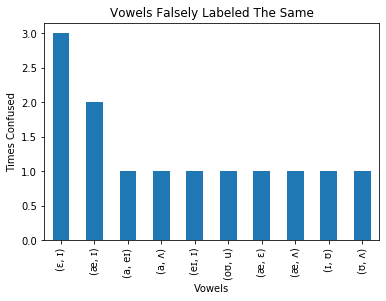

In [7]:
axs = [None,None]
axs[0] = false_diff_data.plot.bar(legend=False,title='Vowels Falsely Labeled Different')
plt.xticks(rotation='horizontal')
axs[1] = confused_vowels.plot.bar(legend=False,title='Vowels Falsely Labeled The Same')
for i in axs:
    i.set_ylabel('Times Confused')
    i.plot()